# Locate receptive fields with simple blobs.



In [1]:
import glob
import os
import numpy as np
import pandas as pd

try:
    namespace = "aakarsh" 
    
    background_dir = f'data/{namespace}/receptive_fields_spline/'
    list_of_background_files = glob.glob(os.path.join(background_dir, '*.npz'))
    list_of_background_files = [f for f in list_of_background_files if 'w_est_spline_coeffs' in f]
    print(f"Found files in '{background_dir}': {list_of_background_files}")
    
    if not list_of_background_files:
        raise FileNotFoundError(f"No background data files found in '{background_dir}'")

    print(f"Found {len(list_of_background_files)} background data files in '{background_dir}'") 
    latest_coefficients_file = max(list_of_background_files, key=os.path.getctime)
    print(f"Loading latest background data from: {latest_coefficients_file}")
    loaded_data = np.load(latest_coefficients_file, allow_pickle=True)
    w_est_spline_coeffs = loaded_data['w_est_spline_coeffs']
    dims = loaded_data['dims']
    print(f"w_est_spline_coeffs loaded with shape: {w_est_spline_coeffs.shape if hasattr(w_est_spline_coeffs, 'shape') else 'N/A'}")
    print(f"Loaded data keys: {loaded_data.keys()}")
except Exception as e:
    print(f"Error loading background data: {e}")
    raise 

Found files in 'data/aakarsh/receptive_fields_spline/': ['data/aakarsh/receptive_fields_spline/w_est_spline_coeffs_2025_07_19_18_39_26.npz', 'data/aakarsh/receptive_fields_spline/w_est_spline_coeffs_2025_07_19_13_43_25.npz']
Found 2 background data files in 'data/aakarsh/receptive_fields_spline/'
Loading latest background data from: data/aakarsh/receptive_fields_spline/w_est_spline_coeffs_2025_07_19_18_39_26.npz
w_est_spline_coeffs loaded with shape: (189, 4480)
Loaded data keys: KeysView(NpzFile 'data/aakarsh/receptive_fields_spline/w_est_spline_coeffs_2025_07_19_18_39_26.npz' with keys: w_est_spline_coeffs, binned_spikes, flattened_off_stimuli, flattened_on_stimuli, stim_h...)


In [38]:
import utils

data = utils.load_data()
data = utils.preprocess_data(data)

Performing initial data preprocessing...
Preprocessing complete.


In [39]:
data.keys()

dict_keys(['t', 'dff', 'stim_table', 'stim', 'roi_masks', 'max_projection', 'running_speed', 'stim_epoch_table', 'preprocessing_done'])

In [2]:
w_est_spline_coeffs.shape

(189, 4480)

In [3]:
# --- Step 5: Hierarchical Clustering Analysis for Spatial Organization ---
# This analyzes whether neurons with similar RFs cluster together physically

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

import importlib

import numpy as np
import utils as U
importlib.reload(U)

<module 'utils' from '/Users/aakarsh/src/TUE-SUMMER-2025/nds-final-project-summer25/utils.py'>

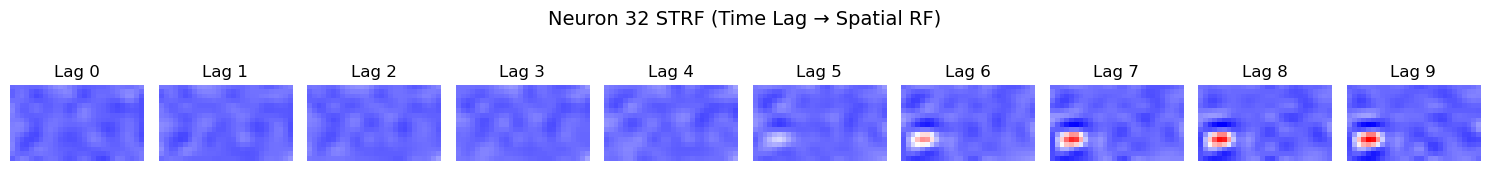

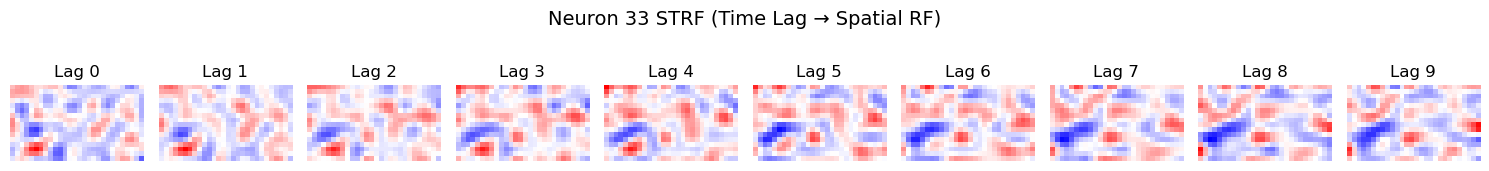

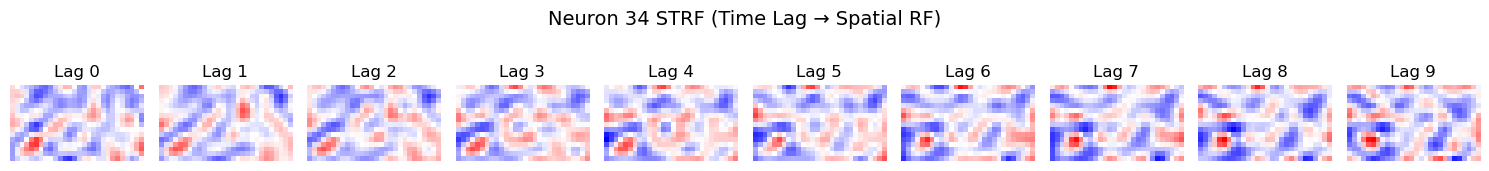

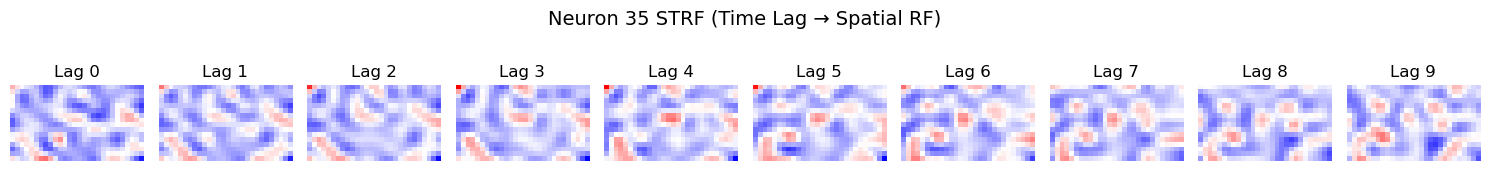

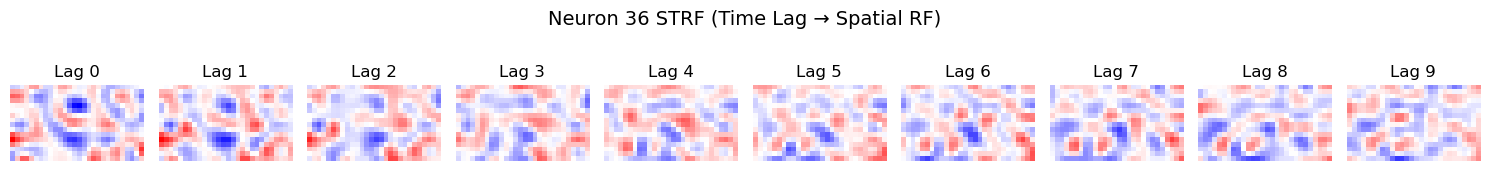

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Reuse dims and selected_neurons
num_lags, stim_h, stim_w = dims
selected_neurons = [32, 33, 34, 35, 36]  # Example neuron indices to visualize
for idx, neuron_idx in enumerate(selected_neurons):
    w_flat = w_est_spline_coeffs[neuron_idx]
    
    # Reshape to (time lags, height, width)
    strf = w_flat.reshape(dims)
    
    # Plot all lags
    fig, axes = plt.subplots(1, num_lags, figsize=(num_lags * 1.5, 2))
    fig.suptitle(f"Neuron {neuron_idx} STRF (Time Lag → Spatial RF)", fontsize=14)

    # Normalize color scale across all lags for fair comparison
    vmin, vmax = strf.min(), strf.max()
    for t in range(num_lags):
        ax = axes[t]
        ax.imshow(strf[t], cmap='bwr', vmin=vmin, vmax=vmax)
        ax.set_title(f"Lag {t}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Localized Receptive Fields

In [30]:
import utils
from scipy.linalg import svd

importlib.reload(utils)

def extract_spatial_rf(w_est_spline_coeffs, dims, selected_neurons=None):
    """
    Extract spatial receptive fields from spline coefficients.
    
    Args:
        w_est_spline_coeffs: Coefficients of the spline fit.
        dims: Dimensions of the receptive field (num_lags, height, width).
        selected_neurons: List of neuron indices to visualize.
    
    Returns:
        List of spatial receptive fields for each selected neuron.
    """
    if selected_neurons is None:
        selected_neurons = range(w_est_spline_coeffs.shape[0])
    spatial_rf_list = []
    for neuron_idx in selected_neurons:
        neuron_west_spline = w_est_spline_coeffs[neuron_idx]
        # Reshape the flattened w_est back into its spatio-temporal form
        strf_spline = neuron_west_spline.reshape(dims)  # (20, 16, 28)

        num_pixels = stim_h * stim_w
        strf_for_vis = strf_spline.transpose(1, 2, 0).reshape(num_pixels, num_lags)

        # Perform SVD to get the separated components
        w_centered = strf_for_vis - strf_for_vis.mean(axis=1, keepdims=True)
        U, _, Vt = svd(w_centered, full_matrices=False)

        spatial_rf = U[:, 0].reshape(stim_h, stim_w)
        temporal_rf = Vt[0, :]

        # Sign correction for consistent plotting
        if np.abs(np.min(spatial_rf)) > np.abs(np.max(spatial_rf)):
            spatial_rf *= -1
            temporal_rf *= -1
            
        spatial_rf_list.append(spatial_rf)
        
    return np.array(spatial_rf_list)

spatial_rfs = extract_spatial_rf(w_est_spline_coeffs, dims)
gaussian_fits_statistics_df = utils.quantify_all_rfs(spatial_rfs) 

Quantifying localization for all spatial RFs...


/Users/aakarsh/src/TUE-SUMMER-2025/nds-final-project-summer25/utils.py:1438: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian_2d, (x, y), rf_map.ravel(), p0=initial_guess)


Quantification complete.


In [31]:
gaussian_fits_statistics_df

,neuron_id,r_squared,rf_size,amplitude,rf_center_x,rf_center_y
0,32,7.980294e-01,1.254756,0.409102,4.104507,10.960805
1,112,7.762630e-01,1.275289,0.396093,5.858431,10.805198
2,120,7.630063e-01,1.340931,0.373918,6.141740,10.673456
3,87,7.436450e-01,1.327739,0.373745,3.712810,11.530277
4,182,7.212877e-01,1.159580,0.416098,5.578175,10.829691
...,...,...,...,...,...,...
184,94,0.000000e+00,NaN,0.000000,NaN,NaN
185,70,-2.220446e-16,0.047945,0.048159,27.614599,3.312984
186,157,-2.220446e-16,7.559021,0.043828,-43.471909,-20.006703
187,106,-2.220446e-16,2.309888,0.010537,42.738200,6.513155


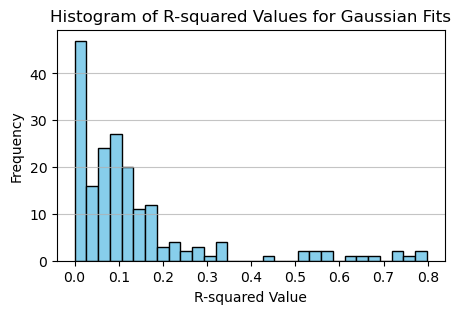

In [32]:
# Plot histogram of R-squared values
plt.figure(figsize=(5, 3))
plt.hist(gaussian_fits_statistics_df['r_squared'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of R-squared Values for Gaussian Fits')
plt.xlabel('R-squared Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [33]:
# Filter neurons with R-squared > 0.5
high_r_squared_neurons = gaussian_fits_statistics_df[gaussian_fits_statistics_df['r_squared'] > 0.5]

In [34]:
high_r_squared_neurons

,neuron_id,r_squared,rf_size,amplitude,rf_center_x,rf_center_y
0,32,0.798029,1.254756,0.409102,4.104507,10.960805
1,112,0.776263,1.275289,0.396093,5.858431,10.805198
2,120,0.763006,1.340931,0.373918,6.141740,10.673456
3,87,0.743645,1.327739,0.373745,3.712810,11.530277
4,182,0.721288,1.159580,0.416098,5.578175,10.829691
5,179,0.668516,3.020953,0.166681,6.322223,12.618535
6,43,0.643597,1.446244,0.310654,4.676575,12.050324
7,50,0.623774,1.100576,0.411854,4.590362,10.963093
8,111,0.568624,1.243492,0.348849,4.440787,10.892501
9,24,0.562344,1.123212,0.382697,5.546003,10.803204


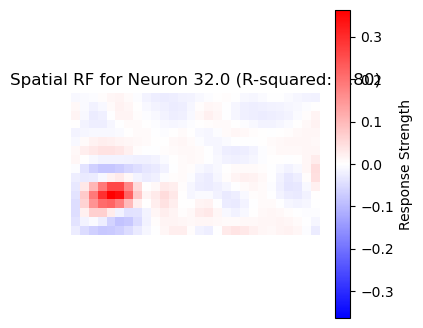

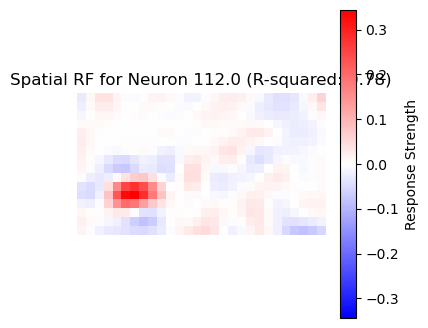

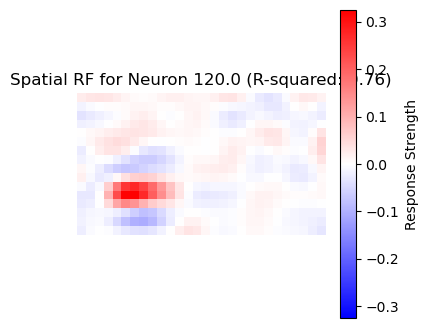

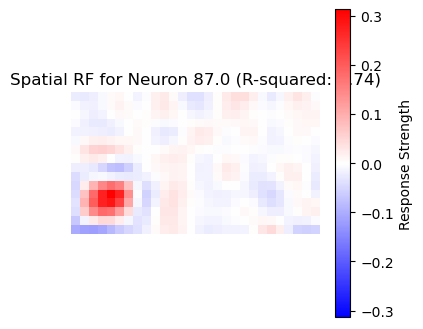

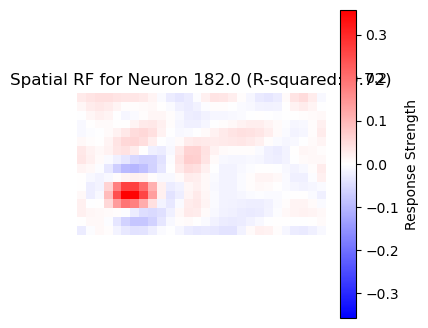

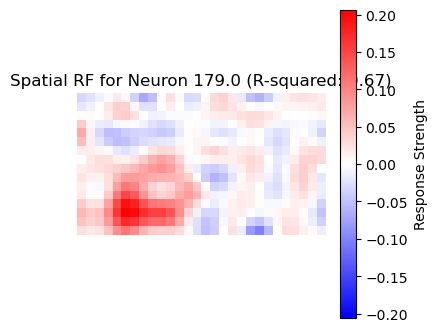

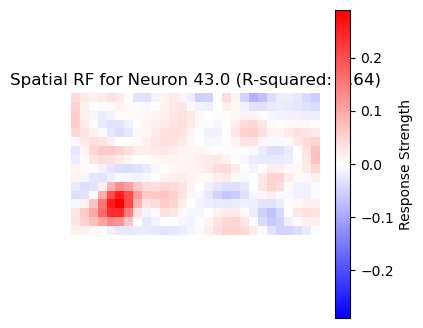

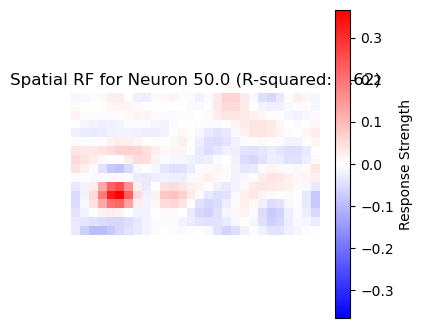

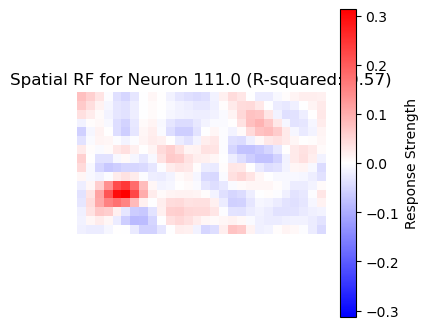

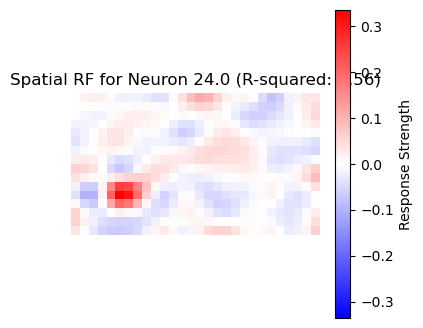

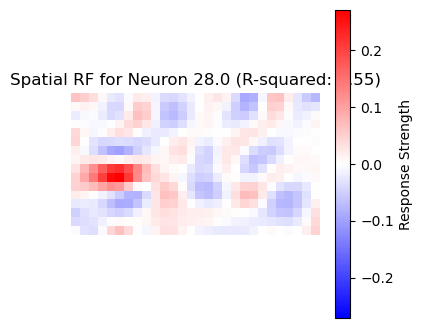

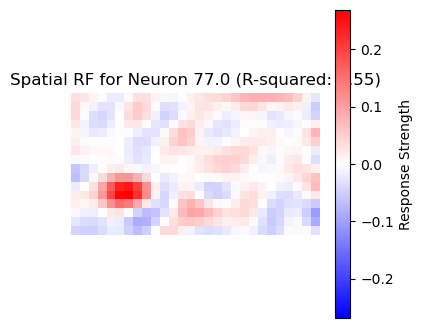

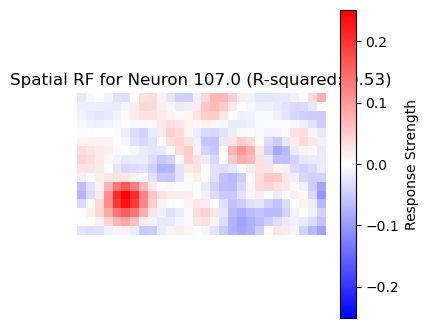

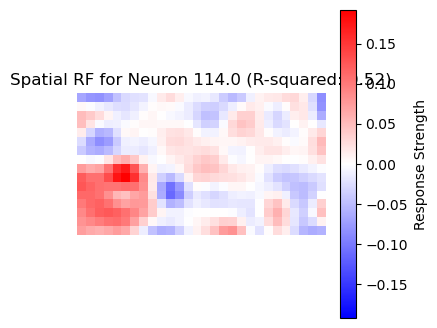

In [37]:
spatial_rfs = extract_spatial_rf(w_est_spline_coeffs, dims, selected_neurons=high_r_squared_neurons['neuron_id'].tolist())
for idx, row in high_r_squared_neurons.iterrows():
    spatial_rf = spatial_rfs[idx]
    plt.figure(figsize=(4, 4))
    plt.imshow(spatial_rf, cmap='bwr', vmin=-np.max(np.abs(spatial_rf)), vmax=np.max(np.abs(spatial_rf)))
    plt.title(f"Spatial RF for Neuron {row['neuron_id']} (R-squared: {row['r_squared']:.2f})")
    plt.colorbar(label='Response Strength')
    plt.axis('off')
    plt.show()

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils as U 
import importlib
import os

# Reload utils to ensure you're using the latest version of your functions
importlib.reload(U) 

print("Starting Phase 4: Final Analysis and Visualization...")

# --- Step 1: Load All Necessary Data ---

try:
    # ACTION: Change 'aakarsh' to your namespace if needed.
    namespace = "aakarsh" 
    
    # Load the original raw data to get ROI masks and max projection
    data = U.load_data() # Assuming the load_data function is in utils.py or defined
    roi_masks = data['roi_masks']
    max_projection_image = data['max_projection']


except (FileNotFoundError, NameError) as e:
    print(f"ERROR: Could not find a necessary input file: {e}")
    print("Please ensure you have run the previous notebooks and saved their outputs correctly.")
    raise


Starting Phase 4: Final Analysis and Visualization...


In [53]:
roi_masks.shape

(189, 512, 512)

Calculating ROI centroid for neuron 32 (1/14)
Calculating centroids of ROI masks...
ROI centroid calculation complete.
Calculating ROI centroid for neuron 112 (2/14)
Calculating centroids of ROI masks...
ROI centroid calculation complete.
Calculating ROI centroid for neuron 120 (3/14)
Calculating centroids of ROI masks...
ROI centroid calculation complete.
Calculating ROI centroid for neuron 87 (4/14)
Calculating centroids of ROI masks...
ROI centroid calculation complete.
Calculating ROI centroid for neuron 182 (5/14)
Calculating centroids of ROI masks...
ROI centroid calculation complete.
Calculating ROI centroid for neuron 179 (6/14)
Calculating centroids of ROI masks...
ROI centroid calculation complete.
Calculating ROI centroid for neuron 43 (7/14)
Calculating centroids of ROI masks...
ROI centroid calculation complete.
Calculating ROI centroid for neuron 50 (8/14)
Calculating centroids of ROI masks...
ROI centroid calculation complete.
Calculating ROI centroid for neuron 111 (9/1

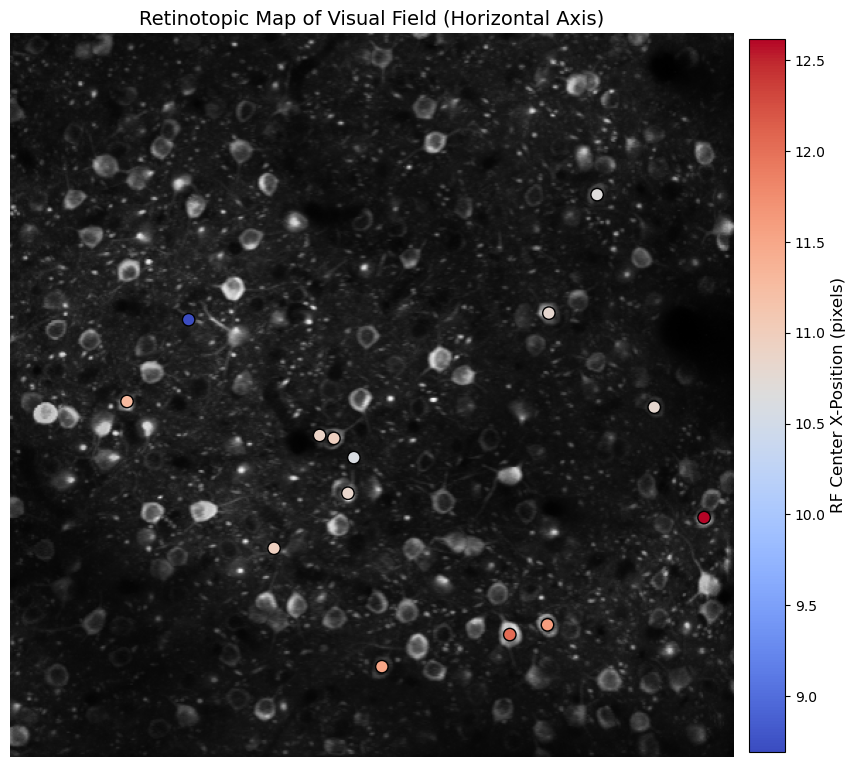

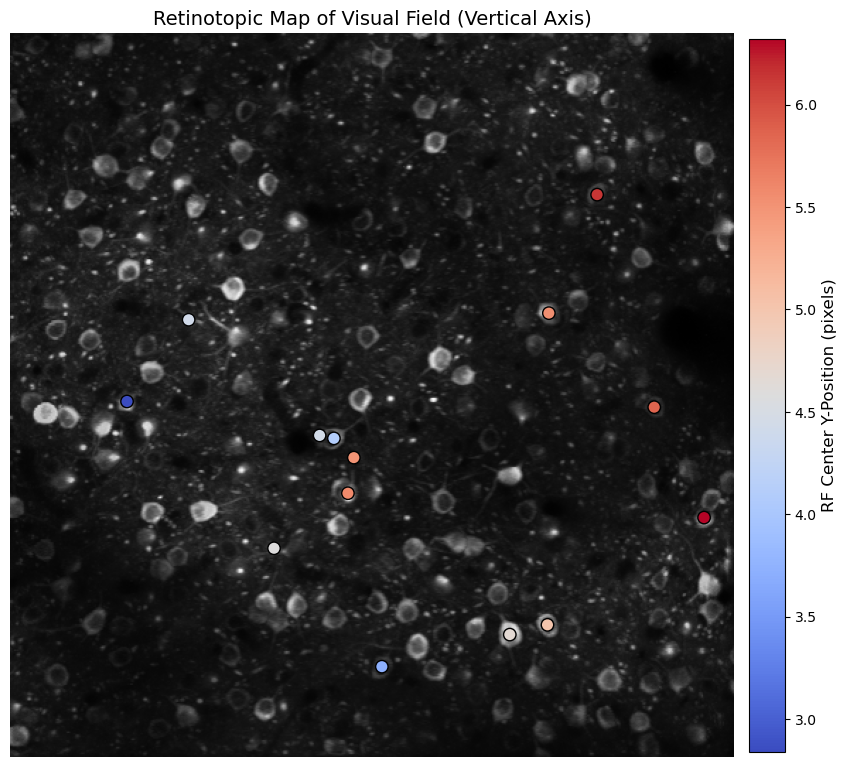

In [57]:
# Calculate the physical (x, y) coordinates for each neuron from its ROI mask
neuron_idxs = high_r_squared_neurons['neuron_id'].tolist() if 'neuron_id' in high_r_squared_neurons.columns else None
roi_centroids = []
for idx, neuron_idx in enumerate(neuron_idxs):
    print(f"Calculating ROI centroid for neuron {neuron_idx} ({idx+1}/{len(neuron_idxs)})") 
    roi_mask_selection = np.array([roi_masks[neuron_idx]])
    roi_centroids.append(U.calculate_roi_centroids(roi_mask_selection))
roi_centroids = np.array(roi_centroids)
roi_centroids = roi_centroids.reshape(-1, 2)  # Ensure shape is (N, 2) for (x, y) coordinates
print(f"All ROI centroids: {roi_centroids.shape}")

# Calculate the functional (x, y) coordinates for each RF from the spatial maps
rf_centers = np.array(list(zip(high_r_squared_neurons['rf_center_x'].values , high_r_squared_neurons['rf_center_y'].values)))
print(f"RF centers shape: {rf_centers.shape if rf_centers is not None else 'N/A'}")
#U.calculate_rf_centers(all_rfs_spatial)


# --- Step 3: Visualize the Retinotopic Map ---
# This is the key visualization that tests the project's hypothesis.
# We create two plots to map the horizontal (X) and vertical (Y) axes.

print("\nGenerating retinotopic maps...")

# Plot 1: Map of the horizontal (X) axis of the visual field
U.plot_retinotopic_map(
    roi_centroids=roi_centroids,
    rf_centers=rf_centers,
    background_image=max_projection_image,
    axis_to_map='x'
)

# Plot 2: Map of the vertical (Y) axis of the visual field
U.plot_retinotopic_map(
    roi_centroids=roi_centroids,
    rf_centers=rf_centers,
    background_image=max_projection_image,
    axis_to_map='y'
)
